### Establish DB connection

In [1]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import FileLink
load_dotenv()  # reads .env

DB_USER = os.getenv("DB_USER")
DB_PASS = os.getenv("DB_PASS")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT", 3306)
DB_NAME = os.getenv("DB_NAME")


### Load datatables into pandas

In [2]:


# 1) Build the connection string
conn_str = (
    f"mysql+pymysql://{DB_USER}:{DB_PASS}"
    f"@{DB_HOST}:{DB_PORT}/{DB_NAME}"
    "?charset=utf8mb4"
)

# 2) Create the engine
engine = create_engine(conn_str, echo=False)

# 3) Load each table you need
apps_df              = pd.read_sql_table("apps",              con=engine)
categories_df        = pd.read_sql_table("categories",        con=engine)
apps_categories_df   = pd.read_sql_table("apps_categories",   con=engine)
reviews_df           = pd.read_sql_table("reviews",           con=engine)
# key_benefits_df      = pd.read_sql_table("key_benefits",      con=engine)
# pricing_plans_df     = pd.read_sql_table("pricing_plans",     con=engine)
# pricing_features_df  = pd.read_sql_table("pricing_plan_features", con=engine)
apps_df = apps_df.drop(columns=['url', 'icon', 'description_raw', 'tagline', 'lastmod', 'pricing_hint', 'developer_link'])


### Join & aggregate into a single feature table
One row per app, with:
- Numerical features:
    - reviews_count already in apps
    - Aggregates over reviews_df (e.g. mean rating, sentiment)
    - Count of pricing plans, key benefits, etc.

- Textual features:
    - App title & description
    - All review text (either concatenated or pooled embeddings)

In [3]:
analyzer = SentimentIntensityAnalyzer()
def safe_sentiment(txt):
    if not isinstance(txt, str):
        return 0.0     # or np.nan, your call
    return analyzer.polarity_scores(txt)['compound']
reviews_df['sentiment'] = reviews_df['body'].apply(safe_sentiment)
rev_agg = (
    reviews_df
    .groupby("app_id")
    .agg(
        avg_rating    = ("rating", "mean"),
        n_reviews     = ("rating", "size"),
        avg_sentiment = ("sentiment", "mean"),
    )
    .reset_index()
)

# Join back to the apps table
apps_feat = (
    apps_df
    .merge(rev_agg, left_on="id", right_on="app_id", how="left")
    .fillna({   # e.g. apps with no reviews
        "avg_rating": apps_df["rating"],
        "n_reviews": 0,
        "avg_sentiment": 0,
    })
)
categories_clean = categories_df.rename(
    columns={
        "id": "category_id",
        "title": "category_title"
    }
)

apps_with_cat = (
    apps_feat
    .merge(apps_categories_df, left_on="id", right_on="app_id", how="left")
    .merge(categories_clean, on="category_id", how="left")
)
print(apps_with_cat.columns)

Index(['id', 'title', 'developer', 'rating', 'reviews_count', 'description',
       'app_id_x', 'avg_rating', 'n_reviews', 'avg_sentiment', 'app_id_y',
       'category_id', 'category_title'],
      dtype='object')


In [4]:
# --- One-hot encode categories per app ---

cat_dummies = pd.get_dummies(
    apps_with_cat["category_title"],
    prefix="cat"
)

apps_cat_ohe = (
    pd.concat([apps_with_cat[["id"]], cat_dummies], axis=1)
      .groupby("id")
      .sum()
      .reset_index()
)

apps_final = apps_feat.merge(
    apps_cat_ohe,
    on="id",
    how="left"
).fillna(0)  # apps with no category will get zeros

print(apps_final.columns)


Index(['id', 'title', 'developer', 'rating', 'reviews_count', 'description',
       'app_id', 'avg_rating', 'n_reviews', 'avg_sentiment',
       ...
       'cat_Widget text', 'cat_Win-back campaigns', 'cat_Win-back emails',
       'cat_Winter', 'cat_Wishlists', 'cat_Workflow automation',
       'cat_XML sitemap', 'cat_ZIP', 'cat_ZIP/post code', 'cat_Zooming'],
      dtype='object', length=1900)


### Model building and analysis

---

Numeric-only explained variance: [0.61676374 0.32041975]


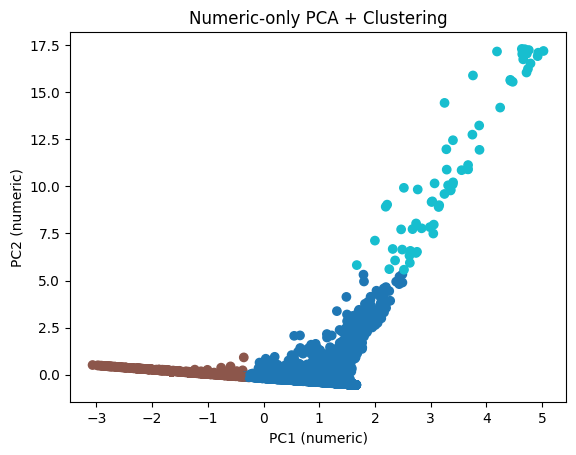

In [5]:
# ---- You can tweak the number of clusters used in KMeans ----
n_clusters = 3
num_cols = ['n_reviews', 'avg_rating', 'avg_sentiment'] 

# Extract and scale:
X_num = apps_final[num_cols].values
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)


# PCA to 2D
pca = PCA(n_components=2, random_state=0)
num_pca = pca.fit_transform(X_num_scaled)
print("Numeric-only explained variance:", pca.explained_variance_ratio_[:2])

# K-Means
km = KMeans(n_clusters=n_clusters, random_state=0)
labels = km.fit_predict(X_num_scaled)

# Attach back & plot
apps_final['PC1'], apps_final['PC2'], apps_final['cluster'] = num_pca[:,0], num_pca[:,1], labels

plt.scatter(apps_final['PC1'], apps_final['PC2'], c=labels, cmap='tab10')
plt.xlabel('PC1 (numeric)'); plt.ylabel('PC2 (numeric)')
plt.title('Numeric-only PCA + Clustering')
plt.show()



### Model analysis:

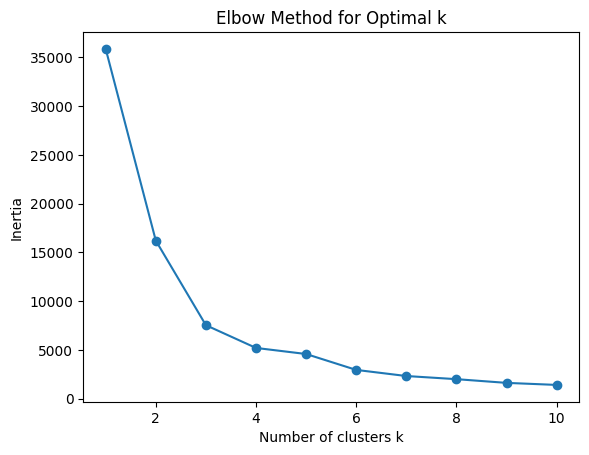

In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertias = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(X_num_scaled)       # or X_combined if you include categories
    inertias.append(km.inertia_)

plt.figure()
plt.plot(K, inertias, marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


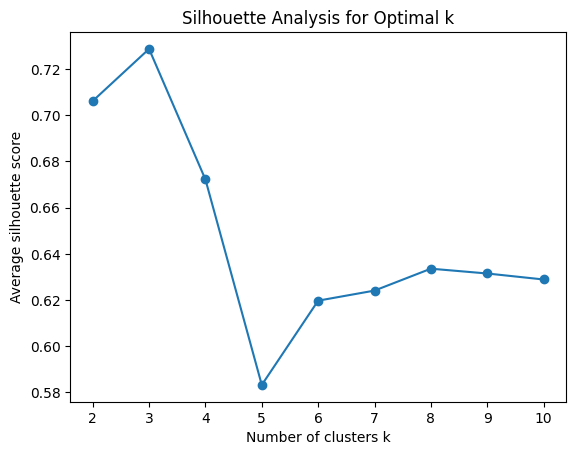

In [7]:
from sklearn.metrics import silhouette_score

sil_scores = []
K = range(2, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    labels = km.fit_predict(X_num_scaled)
    sil_scores.append(silhouette_score(X_num_scaled, labels))

plt.figure()
plt.plot(K, sil_scores, marker='o')
plt.xlabel('Number of clusters k')
plt.ylabel('Average silhouette score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()


### 3 clusters seems the best choice: Highest silhouette score and just where inertia score flattens.

### Adding categorical features into the model adds too much sparsity for PCA! stick to only numeric!

Check Extras for the concrete results

### Visualisations and reasoning

---

C:\Users\sebas\AppData\Local\Temp\ipykernel_26736\1060359297.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cats, rotation=45, ha='right')
C:\Users\sebas\AppData\Local\Temp\ipykernel_26736\1060359297.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cats, rotation=45, ha='right')
C:\Users\sebas\AppData\Local\Temp\ipykernel_26736\1060359297.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cats, rotation=45, ha='right')
C:\Users\sebas\AppData\Local\Temp\ipykernel_26736\1060359297.py:72: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\sebas\anaconda3\envs\shopify-pred\Lib\site-packages\IPython\core\pylabtools.p

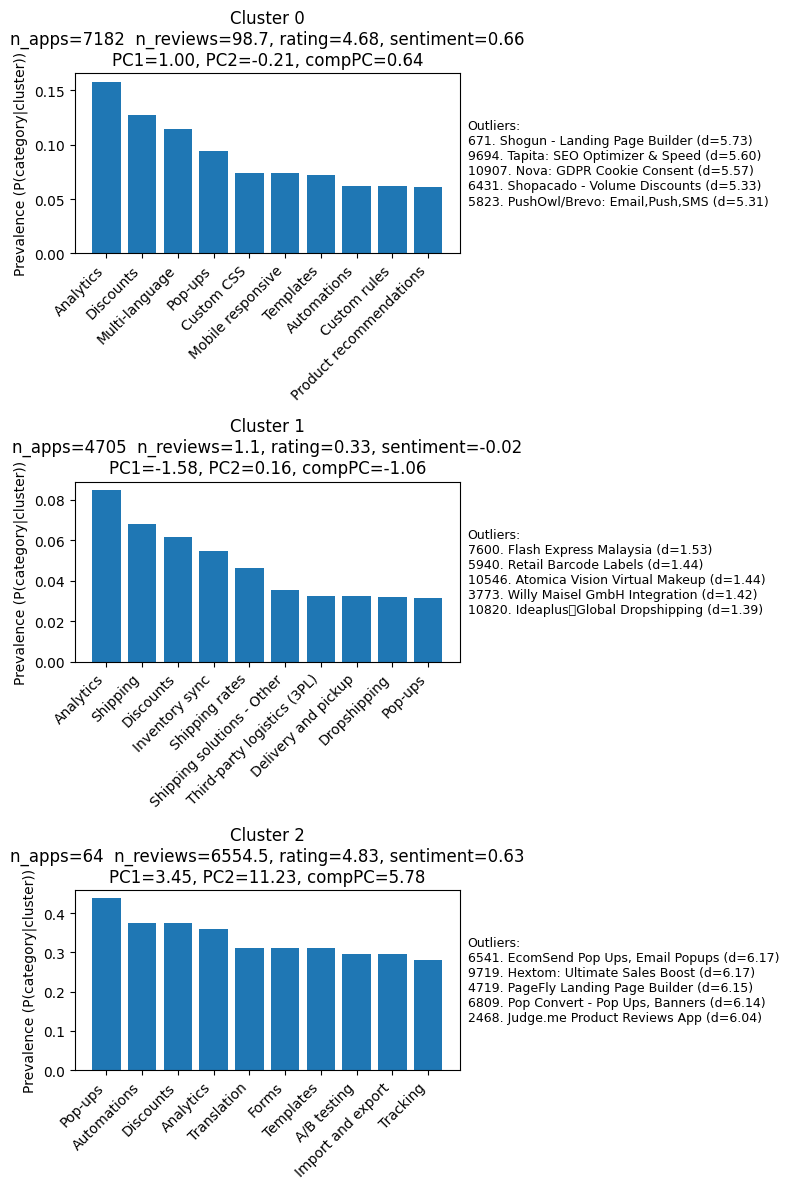

In [18]:
# --- Parameters you can tweak ---
ascending       = False   # sort descending to show top prevalence
num_of_top_cats = 10      # how many categories to show per cluster
num_outliers    = 5       # how many outlier apps to list per cluster

# --- 1. Identify columns & clusters ---
num_cols  = ['n_reviews', 'avg_rating', 'avg_sentiment']
cat_cols  = [c for c in apps_final.columns if c.startswith('cat_')]
clusters  = sorted(apps_final['cluster'].unique())

# --- 2. Compute numeric summaries & centroids ---
grp              = apps_final.groupby('cluster')
numeric_summary  = grp[num_cols + ['PC1','PC2']].mean()
centroids        = numeric_summary[['PC1','PC2']]

# --- 3. Compute outlier distances ---
apps_dist = apps_final.merge(
    centroids, left_on='cluster', right_index=True,
    suffixes=('','_centroid')
)
apps_dist['dist'] = np.sqrt(
    (apps_dist['PC1'] - apps_dist['PC1_centroid'])**2 +
    (apps_dist['PC2'] - apps_dist['PC2_centroid'])**2
)
outliers = {
    cl: apps_dist[apps_dist['cluster']==cl]
            .nlargest(num_outliers, 'dist')[['title','dist']]
    for cl in clusters
}

# --- 4. Compute prevalence P(category|cluster) ---
cluster_sizes    = grp.size().rename('cluster_size')
cat_counts       = grp[cat_cols].sum()
prevalence       = cat_counts.div(cluster_sizes, axis=0)  # P(cat|cl)

# --- 5. Plot per-cluster bar chart of prevalence + annotations ---
cols = 1
rows = len(clusters)
fig, axs = plt.subplots(rows, cols, figsize=(8, 4*rows))
if rows == 1:
    axs = [axs]

for ax, cl in zip(axs, clusters):
    # Top categories by prevalence
    top10 = prevalence.loc[cl].sort_values(ascending=ascending).head(num_of_top_cats)
    cats  = top10.index.str.replace('cat_', '')
    vals  = top10.values

    # Bar plot of prevalence
    ax.bar(cats, vals)
    ax.set_xticklabels(cats, rotation=45, ha='right')
    ax.set_ylabel('Prevalence')

    # Cluster numeric & centroid info
    nr, ar, asent, pc1, pc2 = numeric_summary.loc[cl, ['n_reviews','avg_rating','avg_sentiment','PC1','PC2']]
    composite_pc = pc1*0.7 + pc2*0.3
    ax.set_title(
        f"Cluster {cl}\n"
        f"n_apps={cluster_sizes.loc[cl]}  n_reviews={nr:.1f}, rating={ar:.2f}, sentiment={asent:.2f}\n"
        f"PC1={pc1:.2f}, PC2={pc2:.2f}, compPC={composite_pc:.2f}"
    )

    # List outliers next to plot
    ol = outliers[cl]
    ol_text = "\n".join(f"{i+1}. {row.title} (d={row.dist:.2f})" for i, row in ol.iterrows())
    ax.text(1.02, 0.5, "Outliers:\n" + ol_text,
            transform=ax.transAxes, va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()


### Two clusters are of interest:
 - Cluster 0: moderate reviews, high rating, high sentiment
 - Cluster 1: moderate reviews, low rating, low sentiment

Following code snipped can be used to download the data for these clusters for further analysis

---


In [9]:
##You can change the cluster you want to see here
cluster_id = 2
#You can change the number of top apps you want to see here
top_x = 20
# 1) Make sure compositePC exists on apps_final
apps_final['compositePC'] = apps_final['PC1']*0.7 + apps_final['PC2']*0.3

# 2) Define helper function
def top_apps_in_cluster(cluster_id, top_x=10):
    df = apps_final[apps_final['cluster'] == cluster_id].copy()
    #df = df[df['n_reviews']>50]
    df = df.sort_values('compositePC', ascending=False)
    
    return df.head(top_x)[
        ['title', 'n_reviews', 'avg_rating', 'avg_sentiment', 'PC1', 'PC2', 'compositePC']
    ]

# Usage: get the top 20 apps in cluster 2, for example
top5 = top_apps_in_cluster(cluster_id=cluster_id, top_x=top_x)
print(top5)
# add variance to table

                                title  n_reviews  avg_rating  avg_sentiment  \
4718     PageFly Landing Page Builder     9952.0    4.968750       0.769494   
2467     Judge.me Product Reviews App     9891.0    4.967647       0.729407   
2176        Hextom: Free Shipping Bar     9792.0    4.934845       0.750665   
6808   Pop Convert ‑ Pop Ups, Banners     9946.0    4.942791       0.626605   
9718     Hextom: Ultimate Sales Boost     9962.0    4.806665       0.607014   
6540   EcomSend Pop Ups, Email Popups     9962.0    4.975005       0.547287   
4773    DSers‑AliExpress Dropshipping     9838.0    4.973369       0.624941   
473        Loox ‑ Product Reviews App     9889.0    4.909495       0.582431   
7481     Zendrop ‑ Dropshipping & POD     9816.0    4.758761       0.620190   
7177      Ali Reviews: Kudosi Reviews     9567.0    4.984008       0.717871   
3430          BEST Currency Converter     9669.0    4.743510       0.664225   
10214   Privy ‑ Pop Ups, Email, & SMS     9408.0    

## Download the data:

----
### Export apps from a specifc cluster:

In [26]:
# ---  Specify your cluster of interest and columns to export ---
cluster_id = 2  # ← change this to the cluster number you want
export_cols = [
    'title',
    'n_reviews',
    'avg_rating',
    'avg_sentiment',
    'compositePC'
]

df_cluster_all = apps_final[apps_final['cluster'] == cluster_id][export_cols]


file_path = f"data/apps/cluster_{cluster_id}_all_apps.xlsx"
df_cluster_all.to_excel(file_path, index=False)


display(FileLink(file_path))


D:\WORK\shopifyTrendPredictor\data\apps\cluster_1_all_apps.xlsx

### Export categories from a specific cluster:

In [24]:
# ---  Specify your cluster of interest ---
cluster_id = 2  # ← change this to the cluster number you want


cat_cols = [c for c in apps_final.columns if c.startswith('cat_')]
metrics = ['n_reviews', 'avg_rating', 'avg_sentiment', 'compositePC']


cluster_apps = apps_final[apps_final['cluster'] == cluster_id]
total_apps = len(cluster_apps)


records = []
for cat_col in cat_cols:
    category_name = cat_col.replace('cat_', '')
    subset = cluster_apps[cluster_apps[cat_col] == 1]
    count = len(subset)
    if count == 0:
        # skip categories not present in this cluster
        continue
    prevalence = count / total_apps
    record = {
        'category': category_name,
        'prevalence': prevalence,
        'avg_n_reviews': subset['n_reviews'].mean(),
        'category_avg_rating': subset['avg_rating'].mean(),
        'category_avg_sentiment': subset['avg_sentiment'].mean(),
        'avg_compositePC': subset['compositePC'].mean()
    }
    records.append(record)

cluster_cat_metrics = pd.DataFrame(records)

# --- 5. Save to Excel ---
file_path = f"data/categories/cluster_{cluster_id}_category_metrics.xlsx"
cluster_cat_metrics.to_excel(file_path, index=False)

display(FileLink(file_path))
cluster_cat_metrics


D:\WORK\shopifyTrendPredictor\data\categories\cluster_2_category_metrics.xlsx

,category,prevalence,avg_n_reviews,category_avg_rating,category_avg_sentiment,avg_compositePC
0,404 pages,0.078125,7190.000000,4.898660,0.698793,6.375504
1,A/B testing,0.109375,8060.428571,4.765250,0.596443,6.928052
2,AI copywriting,0.031250,9043.500000,4.471659,0.314562,7.338005
3,AI generation,0.109375,7180.000000,4.875866,0.699945,6.364308
4,AI images and video,0.031250,9043.500000,4.471659,0.314562,7.338005
...,...,...,...,...,...,...
654,Welcome messages,0.062500,6433.500000,4.788295,0.600348,5.641062
655,White label,0.062500,7384.750000,4.718801,0.558588,6.338348
656,Wholesale,0.015625,3606.000000,4.909318,0.784451,3.618507
657,Win-back campaigns,0.031250,6816.000000,4.843606,0.676567,6.041855


## Extras:

---

### Top apps by PC1 or PC2 sepparately

In [9]:


# 1) Identify your one-hot category columns
cat_cols = [c for c in apps_final.columns if c.startswith('cat_')]

# 2) Pick your subsets
high_pc1 = apps_final.nlargest(10, 'PC1')     # top 10 apps by PC1
high_pc2 = apps_final.nlargest(10, 'PC2')     # top 10 apps by PC2

pc1_cat_counts = {}
pc2_cat_counts = {}
for cat in cat_cols:
    mask = apps_final[cat] == 1
    cat_name = cat.replace('cat_', '')
    pc1_cat_counts[cat_name] = apps_final.loc[mask, 'PC1'].mean()
    pc2_cat_counts[cat_name] = apps_final.loc[mask, 'PC2'].mean()
pc1_cat_counts = pd.Series(pc1_cat_counts).sort_values(ascending=False)
pc2_cat_counts = pd.Series(pc2_cat_counts).sort_values(ascending=False)


print("Top 10 by PC1:")
print(high_pc1[['title','PC1','PC2']])

print("\nTop 10 by PC2:")
print(high_pc2[['title','PC1','PC2']])
print('\n--------------------------------------------------\n')

# 5) View the top categories
print("Top categories for high-PC1 apps:")
print(pc1_cat_counts.head(10))

print("\nTop categories for high-PC2 apps:")
print(pc2_cat_counts.head(10))


Top 10 by PC1:
                                title       PC1        PC2
4718     PageFly Landing Page Builder  5.022811  17.174888
2467     Judge.me Product Reviews App  4.928273  17.083491
2176        Hextom: Free Shipping Bar  4.918287  16.901440
7177      Ali Reviews: Kudosi Reviews  4.790024  16.513651
6808   Pop Convert ‑ Pop Ups, Banners  4.759199  17.224759
10214   Privy ‑ Pop Ups, Email, & SMS  4.744386  16.228289
4773    DSers‑AliExpress Dropshipping  4.724745  17.032393
5865      CJdropshipping: Much Faster  4.718396  16.033066
9718     Hextom: Ultimate Sales Boost  4.688476  17.269396
3430          BEST Currency Converter  4.659288  16.730898

Top 10 by PC2:
                               title       PC1        PC2
6540  EcomSend Pop Ups, Email Popups  4.634603  17.283845
9718    Hextom: Ultimate Sales Boost  4.688476  17.269396
6808  Pop Convert ‑ Pop Ups, Banners  4.759199  17.224759
4718    PageFly Landing Page Builder  5.022811  17.174888
5085                          

### Top on **both** PC1 and PC2 (above the 90th percentile)

In [10]:
p1_thr = apps_final['PC1'].quantile(0.90)
p2_thr = apps_final['PC2'].quantile(0.90)

high_both = apps_final[
    (apps_final['PC1'] >= p1_thr) &
    (apps_final['PC2'] >= p2_thr)
]
print("Apps in the top 10% on both PC1 & PC2:")
print(high_both[['title','PC1','PC2']])
print('\n--------------------------------------------------\n')

both_cat_counts = high_both[cat_cols].sum().sort_values(ascending=False)
both_cat_counts.index = both_cat_counts.index.str.replace('cat_', '')

print("Top categories for apps high on both PC1 & PC2:")
print(both_cat_counts.head(10))


Apps in the top 10% on both PC1 & PC2:
                                title       PC1        PC2
71     SearchPie SEO & Speed optimize  2.835657   7.768574
116    Upsell & Cross Sell — Selleasy  1.979658   3.173593
129            17TRACK Order Tracking  2.317413   6.672782
168       Parcel Panel Order Tracking  2.468459   7.712026
178     Trendsi: Fashion Dropshipping  2.624699   5.937392
...                               ...       ...        ...
11815            Facebook & Instagram  3.247650  14.421017
11826    CedCommerce eBay Integration  1.650135   1.869593
11898  KB Back In Stock Restock Alert  2.088163   3.672859
11915            Lifter Pop‑Up Window  1.493346   1.067972
11936          Seal Subscriptions App  1.700868   3.351187

[254 rows x 3 columns]

--------------------------------------------------

Top categories for apps high on both PC1 & PC2:
Analytics            83
Multi-language       82
Discounts            81
Pop-ups              72
Templates            65
Custom C

In [11]:
# #needs some work
# # 1) Pick your cluster
# cluster_id = 0  # ← change this to the cluster number you want
# 
# # 2) Define columns
# num_cols = ['n_reviews', 'avg_rating', 'avg_sentiment']
# cat_cols = [c for c in apps_final.columns if c.startswith('cat_')]
# 
# # 3) Build the summary per cluster
# grp = apps_final.groupby('cluster')
# 
# # Numeric + PCs + composite
# numeric_summary = grp[num_cols + ['PC1','PC2']].mean()
# numeric_summary['compositePC'] = (
#     numeric_summary['PC1']*0.7 + numeric_summary['PC2']*0.3
# )
# 
# # Category prevalence
# cluster_sizes  = grp.size().rename('cluster_size')
# cat_counts     = grp[cat_cols].sum()
# cat_prevalence = cat_counts.div(cluster_sizes, axis=0)
# # rename cols: cat_X → X_prevalence
# cat_prevalence.columns = [c.replace('cat_','') + '_prevalence' for c in cat_prevalence.columns]
# 
# # merge into one DataFrame
# cluster_summary = numeric_summary.join(cat_prevalence)
# 
# # 4) Extract just your chosen cluster
# cluster_df = cluster_summary.loc[[cluster_id]]
# 
# # 5) Save to Excel
# file_path = f"data/categories/cluster_{cluster_id}_summary.xlsx"
# cluster_df.to_excel(file_path, index=True)
# 
# # 6) Display a download link
# display(FileLink(file_path))


D:\WORK\shopifyTrendPredictor\cluster_0_summary.xlsx

Explained variance (num+cat): [0.1491852  0.07802541]


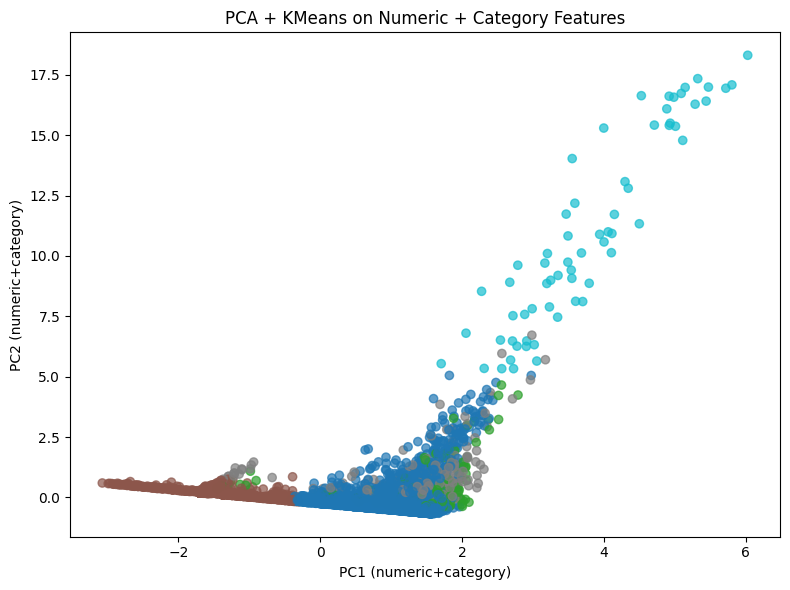

In [12]:
# cat_cols     = [c for c in apps_final.columns if c.startswith('cat_')]
# 
# X_cat = apps_final[cat_cols].values
# 
# # 4) Combine them into one matrix
# X_combined = np.hstack([X_num_scaled, X_cat])
# 
# # 5) PCA → 2 components
# pca = PCA(n_components=2, random_state=0)
# X_pca_cat = pca.fit_transform(X_combined)
# print("Explained variance (num+cat):", pca.explained_variance_ratio_)
# 
# # 6) K-Means on the combined space
# km = KMeans(n_clusters=5, random_state=0)
# labels_cat = km.fit_predict(X_combined)
# 
# # 7) Attach results back to your DataFrame
# apps_final['PC1_numcat']    = X_pca_cat[:, 0]
# apps_final['PC2_numcat']    = X_pca_cat[:, 1]
# apps_final['cluster'] = labels_cat
# 
# # 8) Visualize
# plt.figure(figsize=(8,6))
# plt.scatter(apps_final['PC1_numcat'], apps_final['PC2_numcat'], c=labels_cat, cmap='tab10', alpha=0.7)
# plt.xlabel('PC1 (numeric+category)')
# plt.ylabel('PC2 (numeric+category)')
# plt.title('PCA + KMeans on Numeric + Category Features')
# plt.tight_layout()
# plt.show()

In [13]:
apps_final.groupby('cluster')[num_cols + ['PC1', 'PC2'] + cat_cols ].mean()

,n_reviews,avg_rating,avg_sentiment,PC1,PC2,cat_360 views,cat_3D animations,cat_3D models,cat_3D/AR/VR,cat_404 pages,...,cat_Widget text,cat_Win-back campaigns,cat_Win-back emails,cat_Winter,cat_Wishlists,cat_Workflow automation,cat_XML sitemap,cat_ZIP,cat_ZIP/post code,cat_Zooming
cluster,,,,,,,,,,,,,,,,,,,,,
0,86.497567,4.677923,0.657013,0.992760,-0.226969,0.001475,0.001917,0.002212,0.005161,0.009733,...,0.001032,0.002212,0.001180,0.002360,0.008996,0.026102,0.000442,0.001917,0.010323,0.000442
1,249.182573,4.584543,0.707220,1.114602,0.045991,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.004149,0.008299,0.000000,0.000000,0.004149,0.000000
2,1.075855,0.333176,-0.018584,-1.579742,0.163160,0.001496,0.000641,0.001923,0.008333,0.002564,...,0.000000,0.000641,0.002350,0.000214,0.005128,0.019017,0.000000,0.000641,0.004274,0.000641
3,322.836957,4.384547,0.617211,0.921169,0.225601,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.070652,0.391304,0.000000,0.021739,0.005435,0.000000,0.000000,0.000000,0.000000
4,6496.907692,4.831850,0.635813,3.433425,11.121418,0.000000,0.000000,0.000000,0.000000,0.107692,...,0.000000,0.030769,0.061538,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
grp = apps_final.groupby('cluster')

# Compute numeric means
num_summary = grp[num_cols].mean()

# Compute category sums
cat_sums = grp[cat_cols].sum()

# For each cluster, extract the top 10 categories
top_categories = (
    cat_sums
    .apply(lambda row:
           row
           .sort_values(ascending=False)
           .head(10)
           .index
           .str.replace('cat_', '')  # remove prefix
           .tolist(),
           axis=1)
    .rename('top_10_categories')
)

# 7) Combine into one DataFrame
cluster_summary = (
    num_summary
    .join(top_categories)
    .reset_index()
)

# 8) View
print(cluster_summary.to_string(index=False))

 cluster   n_reviews  avg_rating  avg_sentiment                                                                                                                                                   top_10_categories
       0   86.497567    4.677923       0.657013                       [Analytics, Multi-language, Mobile responsive, Discounts, Custom CSS, Pop-ups, Inventory sync, Shipping, Custom rules, Upsell and cross-sell]
       1  249.182573    4.584543       0.707220 [Discounts, Volume discounts, Percentage discounts, Quantity breaks, Flat discounts, Free shipping, Product bundles, Fixed pricing, Cart discounts, Tiered pricing]
       2    1.075855    0.333176      -0.018584  [Analytics, Shipping, Discounts, Inventory sync, Shipping rates, Shipping solutions - Other, Third-party logistics (3PL), Delivery and pickup, Dropshipping, Chat]
       3  322.836957    4.384547       0.617211                               [Pop-ups, Discounts, Templates, Analytics, Editor tool, Triggers and rules